In [ ]:
# Without hand tracking, masi kurang akurat kalo pake live cam

In [24]:
import os
import cv2
import shutil
from sklearn.model_selection import train_test_split

In [25]:
dataset_dir = './data/' 
output_dir = './output_ttv/'  

In [5]:

# Ratios for splitting: 70% train, 15% validation, 15% test
train_ratio = 0.7
validation_ratio = 0.15
test_ratio = 0.15

def split_data(class_dir, class_name, output_dir, train_ratio=0.7, validation_ratio=0.15, test_ratio=0.15):
    files = [os.path.join(class_dir, f) for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]
    
    for subset in ['train', 'validation', 'test']:
        subset_dir = os.path.join(output_dir, subset, class_name)
        os.makedirs(subset_dir, exist_ok=True)
    
    if len(files) <= 2:
        if len(files) == 1:
            for subset in ['train', 'validation', 'test']:
                shutil.copy(files[0], os.path.join(output_dir, subset, class_name))
        elif len(files) == 2:
            # If two files, use one for training and one for testing or validation
            shutil.copy(files[0], os.path.join(output_dir, 'train', class_name))
            # Randomly choose whether the second sample goes to validation or test
            if np.random.rand() < 0.5:
                shutil.copy(files[1], os.path.join(output_dir, 'validation', class_name))
                shutil.copy(files[1], os.path.join(output_dir, 'test', class_name))
        print(f"Class {class_name} has less than 3 samples, assigning directly without splitting.")
    else:
        train_val_files, test_files = train_test_split(files, test_size=test_ratio)
        train_files, val_files = train_test_split(train_val_files, test_size=validation_ratio / (validation_ratio + train_ratio))
        
        for f in train_files:
            shutil.copy(f, os.path.join(output_dir, 'train', class_name))
        for f in val_files:
            shutil.copy(f, os.path.join(output_dir, 'validation', class_name))
        for f in test_files:
            shutil.copy(f, os.path.join(output_dir, 'test', class_name))

import numpy as np

output_dir = './output_ttv/'
for class_name in os.listdir(dataset_dir):
    class_dir = os.path.join(dataset_dir, class_name)
    if os.path.isdir(class_dir):
        split_data(class_dir, class_name, output_dir)


print("Dataset successfully split into training, validation, and test sets.")


Dataset successfully split into training, validation, and test sets.


In [26]:
input_dir_path = './output_ttv/'
output_frames_path = './output_frame/'

In [27]:
frame_rate = 1

def extract_frames(video_path, output_dir, frame_rate):
    video = cv2.VideoCapture(video_path)
    video_fps = int(video.get(cv2.CAP_PROP_FPS))
    success, frame = video.read()
    frame_count = 0

    while success:
        if frame_count % (video_fps // frame_rate) == 0:
            frame_path = os.path.join(output_dir, f'{frame_count}.jpg')
            cv2.imwrite(frame_path, frame)

        success, frame = video.read()
        frame_count += 1
    
    video.release()


# Function to create directories if they don't exist
def ensure_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

for set_name in ['train', 'validation', 'test']:
    set_path = os.path.join(input_dir_path, set_name)
    for class_name in os.listdir(set_path):
        class_path = os.path.join(set_path, class_name)
        if not os.path.isdir(class_path):  # Skip if not a directory
            continue
        output_class_path = os.path.join(output_frames_path, set_name, class_name)
        ensure_dir(output_class_path)

        for video_name in os.listdir(class_path):
            video_path = os.path.join(class_path, video_name)
            if not video_name.lower().endswith(('.mp4', '.mov')):  
                continue
            output_video_path = os.path.join(output_class_path, video_name.split('.')[0])
            ensure_dir(output_video_path)

            extract_frames(video_path, output_video_path, frame_rate)

print("Frame extraction completed.")
    
    

Frame extraction completed.


In [28]:
def preprocess_images(input_dir, output_dir, img_size=(224, 224), augment=False):
    # Ensure the base output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Recursively walk through the input directory
    for root, dirs, files in os.walk(input_dir):
        for file in files:
            # Skip non-image files
            if not file.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue

            # Construct the path to the input image and read it
            img_path = os.path.join(root, file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue  # Skip files that aren't valid images

            # Convert the image from BGR to RGB, resize it, and normalize pixel values
            img_resized = cv2.resize(img, img_size)
            img_normalized = img_resized / 255.0

            relative_path = os.path.relpath(root, input_dir)
            output_img_dir = os.path.join(output_dir, relative_path)
            os.makedirs(output_img_dir, exist_ok=True)
            
            img_preprocessed = cv2.cvtColor((img_normalized * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)
            output_path = os.path.join(output_img_dir, file)
            cv2.imwrite(output_path, img_preprocessed)

input_frames_dir = './output_frame/' 
output_preprocessed_dir = './frames_preprocessed/'  
preprocess_images(input_frames_dir, output_preprocessed_dir)

In [3]:
# Ratios for splitting: 70% train, 15% validation, 15% test
train_ratio = 0.7
validation_ratio = 0.15
test_ratio = 0.15

def split_data(class_dir, class_name, output_dir, train_ratio=0.7, validation_ratio=0.15, test_ratio=0.15):
    files = [os.path.join(class_dir, f) for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]
    
    # Ensure the directory exists for each subset
    for subset in ['train', 'validation', 'test']:
        subset_dir = os.path.join(output_dir, subset, class_name)
        os.makedirs(subset_dir, exist_ok=True)
    
    # Handle classes with 1 or 2 files differently to avoid errors
    if len(files) <= 2:
        if len(files) == 1:
            # If only one file, copy it to all subsets
            for subset in ['train', 'validation', 'test']:
                shutil.copy(files[0], os.path.join(output_dir, subset, class_name))
        elif len(files) == 2:
            # If two files, use one for training and one for testing or validation
            shutil.copy(files[0], os.path.join(output_dir, 'train', class_name))
            # Randomly choose whether the second sample goes to validation or test
            if np.random.rand() < 0.5:
                shutil.copy(files[1], os.path.join(output_dir, 'validation', class_name))
                shutil.copy(files[1], os.path.join(output_dir, 'test', class_name))
        print(f"Class {class_name} has less than 3 samples, assigning directly without splitting.")
    else:
        train_val_files, test_files = train_test_split(files, test_size=test_ratio)
        train_files, val_files = train_test_split(train_val_files, test_size=validation_ratio / (validation_ratio + train_ratio))
        
        for f in train_files:
            shutil.copy(f, os.path.join(output_dir, 'train', class_name))
        for f in val_files:
            shutil.copy(f, os.path.join(output_dir, 'validation', class_name))
        for f in test_files:
            shutil.copy(f, os.path.join(output_dir, 'test', class_name))

import numpy as np

dataset_dir = './data2/'
output_dir = './data22/'
for class_name in os.listdir(dataset_dir):
    class_dir = os.path.join(dataset_dir, class_name)
    if os.path.isdir(class_dir):
        split_data(class_dir, class_name, output_dir)


print("Dataset successfully split into training, validation, and test sets.")

Dataset successfully split into training, validation, and test sets.


In [9]:
import tensorflow as tf

# Define the paths to your preprocessed data
train_dir = './frames_preprocessed/train/'
val_dir = './frames_preprocessed/validation'
test_dir = './frames_preprocessed/test'

# Set up data generators
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
val_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Load and iterate datasets
train_data = train_gen.flow_from_directory(train_dir, target_size=(224, 224), color_mode='grayscale', class_mode='categorical')
val_data = val_gen.flow_from_directory(val_dir, target_size=(224, 224), color_mode='grayscale', class_mode='categorical')
test_data = test_gen.flow_from_directory(test_dir, target_size=(224, 224), color_mode='grayscale', class_mode='categorical')



Found 307 images belonging to 26 classes.


Found 253 images belonging to 26 classes.
Found 270 images belonging to 26 classes.


In [10]:
print(train_data.class_indices)
print(val_data.class_indices)
print(test_data.class_indices)


{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25}
{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25}
{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25}


In [11]:
#define the model
from tensorflow import keras
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Sequential

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(26, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

In [9]:
print('Number of classes:', len(train_data.class_indices))


Number of classes: 26


In [12]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])# Compile the model


In [13]:
#train the model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
epochs = 100
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(
    train_data,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    epochs=epochs,
    validation_data=val_data,
    validation_steps=val_data.samples // val_data.batch_size,
    callbacks=[early_stopping]
    # callbacks=[EarlyStopping(patience=3), ModelCheckpoint('best_model.h5', save_best_only=True)]
)


Epoch 1/100
9/9 [==============================] - 12s 1s/step - loss: 3.2711 - accuracy: 0.0327 - val_loss: 3.2487 - val_accuracy: 0.0580
Epoch 2/100
9/9 [==============================] - 10s 1s/step - loss: 3.2353 - accuracy: 0.0400 - val_loss: 3.2516 - val_accuracy: 0.0223
Epoch 3/100
9/9 [==============================] - 10s 1s/step - loss: 3.2078 - accuracy: 0.0582 - val_loss: 3.2676 - val_accuracy: 0.0625
Epoch 4/100
9/9 [==============================] - 10s 1s/step - loss: 3.1414 - accuracy: 0.0909 - val_loss: 3.1851 - val_accuracy: 0.1071
Epoch 5/100
9/9 [==============================] - 10s 1s/step - loss: 2.9490 - accuracy: 0.1745 - val_loss: 3.0048 - val_accuracy: 0.2723
Epoch 6/100
9/9 [==============================] - 10s 1s/step - loss: 2.7005 - accuracy: 0.2582 - val_loss: 2.7533 - val_accuracy: 0.2991
Epoch 7/100
9/9 [==============================] - 10s 1s/step - loss: 2.4474 - accuracy: 0.3200 - val_loss: 2.6551 - val_accuracy: 0.3125
Epoch 8/100
9/9 [==========

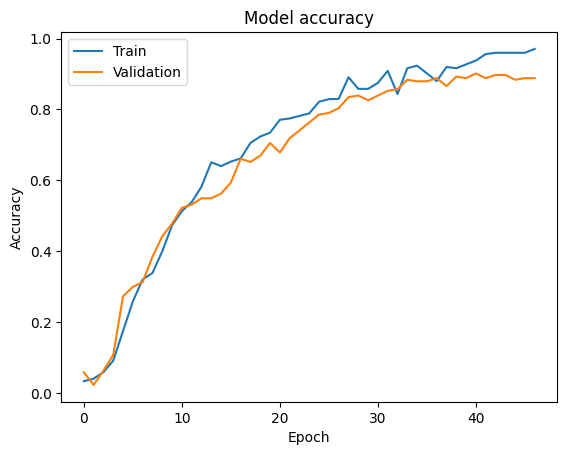

In [14]:
#plot the training and validation accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()




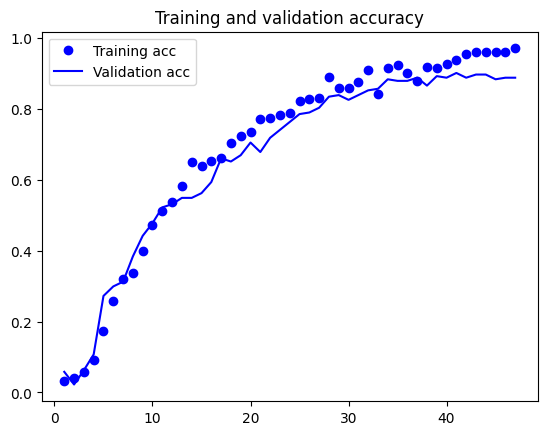

In [15]:
#plot the training and validation accuracy and loss at each epoch
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()



In [16]:
#evaluate the model
test_loss, test_acc = model.evaluate(test_data, steps=test_data.samples // test_data.batch_size)
print(f"Test accuracy: {test_acc*100:.2f}%")


8/8 [==============================] - 2s 271ms/step - loss: 2.0697 - accuracy: 0.8477
Test accuracy: 84.77%


In [17]:
#save the model
model.save('sign_language_model2.keras')

In [20]:
#load the model
model = keras.models.load_model('sign_language_model2.keras')

#predict the class of an image
import numpy as np
from keras.preprocessing import image

img_path = './frames_preprocessed/test/A/A/180.jpg'
img = image.load_img(img_path, target_size=(224, 224), color_mode='grayscale')
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0
predictions = model.predict(img_array)
predicted_class = train_data.class_indices
print(predicted_class)
print(predictions)
predicted_class = list(predicted_class.keys())[np.argmax(predictions)]
print(predicted_class)




1/1 [==============================] - 0s 133ms/step
{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25}
[[9.9993837e-01 6.0039652e-05 3.1538295e-07 5.2503801e-10 3.2714043e-09
  1.3122829e-07 9.7834219e-10 6.4143019e-10 2.8654253e-11 1.3959774e-11
  5.0100309e-11 3.2710069e-08 1.4929692e-09 1.5170182e-09 4.4037593e-13
  4.4824868e-09 2.6268868e-10 6.8301538e-09 7.6648945e-08 1.0827222e-06
  3.4523912e-10 4.7097433e-13 3.5438205e-10 9.7914299e-10 2.0120172e-08
  3.4147331e-11]]
A


In [23]:
#live prediction
import cv2
import numpy as np
from keras.preprocessing import image

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        continue

    cv2.rectangle(frame, (100, 100), (300, 300), (255, 255, 255), 2)
    roi = frame[100:300, 100:300]
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    predictions = model.predict(img_array)
    predicted_class = train_data.class_indices
    predicted_class = list(predicted_class.keys())[np.argmax(predictions)]
    cv2.putText(frame, predicted_class, (100, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    cv2.imshow('Sign Language Recognition', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()



1/1 [==============================] - 0s 27ms/step


: 

In [22]:
#live prediction with hand tracking
import cv2
import numpy as np
from keras.preprocessing import image
import mediapipe as mp

mp_hands = mp.solutions.hands
hands = mp_hands.Hands()
mp_drawing = mp.solutions.drawing_utils

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        continue

    results = hands.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

    cv2.imshow('Hand Tracking', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()



I0000 00:00:1707594216.403000       1 gl_context.cc:344] GL version: 2.1 (2.1 INTEL-20.6.4), renderer: Intel(R) Iris(TM) Plus Graphics OpenGL Engine


In [11]:
#live prediction with hand tracking and show the letter prediction in the frame
import cv2
import numpy as np
from keras.preprocessing import image
import mediapipe as mp

mp_hands = mp.solutions.hands

hands = mp_hands.Hands()
mp_drawing = mp.solutions.drawing_utils

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        continue

    results = hands.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)
            img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (224, 224))
            img_array = image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = img_array / 255.0
            predictions = model.predict(img_array)
            predicted_class = train_data.class_indices
            predicted_class = list(predicted_class.keys())[np.argmax(predictions)]
            cv2.putText(frame, predicted_class, (100, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

    cv2.imshow('Sign Language Recognition', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()



I0000 00:00:1707718353.193625       1 gl_context.cc:344] GL version: 2.1 (2.1 INTEL-20.6.4), renderer: Intel(R) Iris(TM) Plus Graphics OpenGL Engine
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


1/1 [==============================] - 0s 31ms/step


KeyboardInterrupt: 

In [76]:
#live prediction with larger rectangle
import cv2
import numpy as np
from keras.preprocessing import image
import mediapipe as mp

mp_hands = mp.solutions.hands

hands = mp_hands.Hands()
mp_drawing = mp.solutions.drawing_utils

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        continue

    results = hands.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)
            x = int(hand_landmarks.landmark[mp_hands.HandLandmark.WRIST].x * frame.shape[1])
            y = int(hand_landmarks.landmark[mp_hands.HandLandmark.WRIST].y * frame.shape[0])
            img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (224, 224))
            img_array = image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = img_array / 255.0
            predictions = model.predict(img_array)
            predicted_class = train_data.class_indices
            predicted_class = list(predicted_class.keys())[np.argmax(predictions)]
            cv2.putText(frame, predicted_class, (x - 100, y - 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

    cv2.imshow('Sign Language Recognition', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()



I0000 00:00:1707561267.852508       1 gl_context.cc:344] GL version: 2.1 (2.1 INTEL-20.6.4), renderer: Intel(R) Iris(TM) Plus Graphics OpenGL Engine


1/1 [==============================] - 0s 29ms/step
